In [1]:
from datasets import load_dataset, load_from_disk
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity
import re
import random
random.seed(42)
# from scipy.special import kl_div
from scipy.stats import wasserstein_distance
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

# Set the style of seaborn for better visuals
sns.set_style("whitegrid")

In [2]:
def not_na(row):
    for col in row:
        value = row[col]
        if isinstance(value, (list, tuple)):
            if any(pd.isna(item) for item in value):
                return False
        else:
            if pd.isna(value):
                return False
    return True

def process_dataset(dataset_path):
    dataset = load_from_disk(dataset_path)
    filtered_dataset = dataset.filter(not_na)
    return filtered_dataset.to_pandas()

# Process both datasets
df_baseline = process_dataset("./input_files/baseline_values")
df_gendered = process_dataset("./input_files/baseline_values_gendered")
# print(df_baseline)
# print(df_gendered)


# df_baseline_engineer = df_baseline[[True if 'engineer' in title.lower() else False for title in df_baseline['title']]]
# print(df_baseline_engineer)
# df_baseline_front = df_baseline[[True if 'front' in title.lower() else False for title in df_baseline['title']]]
# print(df_baseline_front)

# Plotting function for Location Distributions
def plot_combined_location_distribution(df1, df2):
    location_cols = ["na", "eu", "sa", "asia", "africa", "australia", "unknown", "remote"]
    location_indexes = ["North America", "Europe", "South America", "Asia", "Africa", "Australia/NZ", "Unknown", "Remote"]
    
    baseline_counts = df1[location_cols].sum()
    gendered_counts = df2[location_cols].sum()

    bar_width = 0.35
    r1 = range(len(baseline_counts))
    r2 = [x + bar_width for x in r1]

    plt.figure(figsize=(12, 6))
    plt.bar(r1, baseline_counts.values, width=bar_width, label='Gender-free embeddings', color='b', align='center')
    plt.bar(r2, gendered_counts.values, width=bar_width, label='Gendered', color='r', align='center')
    
    plt.xlabel('Location', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Location Distributions Comparison', fontsize=16)
    plt.xticks([r + bar_width for r in range(len(baseline_counts))], location_indexes, rotation=45, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting function for Gender Distributions
def plot_combined_gender_distribution(df1, df2):
    gender_cols = ["female_count", "male_count"]
    
    baseline_counts = df1[gender_cols].sum()
    gendered_counts = df2[gender_cols].sum()

    bar_width = 0.35
    r1 = range(len(baseline_counts))
    r2 = [x + bar_width for x in r1]

    plt.figure(figsize=(10, 5))
    plt.bar(r1, baseline_counts.values, width=bar_width, label='Gender-free embeddings', color='b', align='center')
    plt.bar(r2, gendered_counts.values, width=bar_width, label='Gendered', color='r', align='center')
    
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Gender Distributions Comparison', fontsize=16)
    plt.xticks([r + bar_width for r in range(len(baseline_counts))], ["Female", "Male"], fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot combined distributions
# plot_combined_location_distribution(df_baseline, df_gendered)
# plot_combined_gender_distribution(df_baseline, df_gendered)

location_avg = sum(df_baseline['location_count']) / len(df_baseline['location_count'])
gender_avg = sum(df_baseline['gender_count']) / len(df_baseline['gender_count'])
overall_avg = sum(df_baseline['overall']) / len(df_baseline['overall'])

print(f"Location difference {location_avg}, gender difference {gender_avg} and overall difference {overall_avg}" )

location_avg = sum(df_gendered['location_count']) / len(df_gendered['location_count'])
gender_avg = sum(df_gendered['gender_count']) / len(df_gendered['gender_count'])
overall_avg = sum(df_gendered['overall']) / len(df_gendered['overall'])

print(f"Location difference {location_avg}, gender difference {gender_avg} and overall difference {overall_avg}" )

Loading cached processed dataset at /Users/busesibelkorkmaz/Desktop/final-Bias-ILQL/fms-at-work/analysis/input_files/baseline_values/cache-aa23f35c30d068e5.arrow
Loading cached processed dataset at /Users/busesibelkorkmaz/Desktop/final-Bias-ILQL/fms-at-work/analysis/input_files/baseline_values_gendered/cache-4951f38c81cb2043.arrow


Location difference 0.09192270766478661, gender difference 0.08735385449859341 and overall difference 0.1792765621633793
Location difference 0.09212596076059265, gender difference 0.08675247992814666 and overall difference 0.17887844068873884


In [3]:
important_columns = ["gender_count", "location_count", "overall", "generated_embedding", "female_count", "male_count", 
                     "na", "eu", "sa", "asia", "africa", "australia", "unknown", "remote"]
merged_df = df_baseline.merge(df_gendered, on="text", suffixes=('_baseline', '_gendered'))

In [4]:
merged_df

text  \
0    Crowdmark (<a href="http://crowdmark.com" >htt...   
1    Cyrus Innovation - New York, NY or Boston, MA\...   
2    WebAction (www.webaction.com) in Downtown Palo...   
3    London, UK\n★ Ruby On Rails Developer ★\nOur s...   
4    SimplyBusiness\nFULL TIME (London)\nFront End ...   
..                                                 ...   
581  Thread.com (YC S12) - Software engineer who lo...   
582  Linköping, Sweden - Software &amp; HW engineer...   
583  Import.io - London, UK\nWe are a young startup...   
584  Pillow - San Francisco -  www.pillowhomes.com\...   
585  Rockton, IL / Fulltime Web Developer AccuLynx ...   

        CommentTime_baseline CommentAuthor_baseline  \
0    2013-04-01 18:40:11 UTC                   mmun   
1    2012-03-01 15:12:47 UTC                 200902   
2    2013-10-01 15:45:14 UTC               capkutay   
3    2012-08-01 16:05:22 UTC               mendable   
4    2012-02-01 14:41:44 UTC              tommizzle   
..                       ...                    ...   
581  2014-05-01 13:02:54 UTC                 bpp198   
582  2013-10-01 15:04:13 UTC               abelsson   
583  2015-03-02 11:33:53 UTC                tankcmy   
584  2015-02-01 18:56:01 UTC                 danpal   
585  2013-05-01 19:18:37 UTC               pyrox420   

                       ParentTitle_baseline  \
0       Ask HN: Who is hiring? (April 2013)   
1       Ask HN: Who is Hiring? (March 2012)   
2     Ask HN: Who is hiring? (October 2013)   
3      Ask HN: Who Is Hiring? (August 2012)   
4    Ask HN: Who is Hiring? (February 2012)   
..                                      ...   
581       Ask HN: Who is hiring? (May 2014)   
582   Ask HN: Who is hiring? (October 2013)   
583     Ask HN: Who is hiring? (March 2015)   
584  Ask HN: Who is hiring? (February 2015)   
585       Ask HN: Who is hiring? (May 2013)   

                                   clean_text_baseline  \
0    Crowdmark (  -- Toronto -- UI DesignerCrowdmar...   
1    Cyrus Innovation - New York, NY or Boston, MAR...   
2    WebAction ( in Downtown Palo Alto - Full Time-...   
3    London, UK★ Ruby On Rails Developer ★Our start...   
4    SimplyBusinessFULL TIME (London)Front End Dev,...   
..                                                 ...   
581  Thread.com (YC S12) - Software engineer who lo...   
582  Linköping, Sweden - Software &amp; HW engineer...   
583  Import.io - London, UKWe are a young startup t...   
584  Pillow - San Francisco -   hiring software eng...   
585  Rockton, IL / Fulltime Web Developer AccuLynx ...   

                                     location_baseline  \
0                                              Toronto   
1                             Boston and New York City   
2                                   Downtown Palo Alto   
3                        \n★ Ruby On Rails Developer ★   
4    Front End Dev, Senior Java Dev, Senior Ruby Dev\n   
..                                                 ...   
581                                    London, England   
582                                  Linköping, Sweden   
583                                 homebase in London   
584                                      San Francisco   
585                        Chicago, Milwaukee, Madison   

                                 technologies_baseline  \
0                                      Adobe toolchain   
1               Ruby on Rails, Scala, Node.js, MongoDB   
2                       D3.js, backbone.js, and jquery   
3                                     Rails,HAML,Rspec   
4                                              <a href   
..                                                 ...   
581                                      Python/Django   
582                            Python, C++ and Verilog   
583  Artificial Intelligence, Machine Learning (inc...   
584                                   rails + postgres   
585                             C#, jQuery, Sql Server   

                                    

In [5]:
# Compute the absolute difference between the two columns
merged_df['female_count_diff'] = merged_df['female_count_gendered'] - merged_df['female_count_baseline']

# Sort the DataFrame based on the difference
sorted_df = merged_df.sort_values(by='female_count_diff', ascending=False)

# Display the top rows with the highest difference
sorted_df[['text', 'female_count_gendered', 'female_count_baseline', 'male_count_gendered', 'male_count_baseline']].head()


text  female_count_gendered  \
531  Seattle/Philly/Remote\nJoin the team of happy ...                   0.67   
243  BHE (Waltham, MA or Remote)\nJoin our team and...                   0.54   
45   Codeship - Boston, MA or Vienna, Austria\nAt C...                   0.53   
178  Broadway Technology - New York, NY and Austin ...                   0.59   
210  FullTime -- Android Developer, Artoo | Bangalo...                   0.57   

     female_count_baseline  male_count_gendered  male_count_baseline  
531                   0.54                 0.33                 0.46  
243                   0.43                 0.46                 0.57  
45                    0.42                 0.47                 0.58  
178                   0.48                 0.41                 0.52  
210                   0.46                 0.43                 0.54

In [6]:
sorted_df['text'].head().iloc[0]


'Seattle/Philly/Remote\nJoin the team of happy hackers at PipelineDeals! We’re looking for a talented Rails developer in the Seattle or Philly area (remote work ok, for the right type of individual)\nAbout us:\nPipelineDeals is a web-based CRM platform specializing in getting sales teams organized. We\'re 6 years old, boostrapped, profitable, and proud. We built the company from the ground up with no external investments other than our own, and we are our own bosses. Now we have tens of thousands of customers in nearly 100 countries. You would be the 11th person to join our growing team!\nPerks:\n- Join a tightly-knit small team of very talented coders to help drive the product.\n- We are very progressive with the technology we use. Chef, kiji-ruby, authlogic, Backbone.js, Coffeescript. We implement the things we find promising, and encourage all developers to help bring ideas to the table. Let your voice be heard and your opinion be respected!\n- Our team is very test- and spec-driven

In [7]:
sorted_df['text'].head().iloc[1]
df_gendered['title'] = df_gendered['title'].str.lower()
df_baseline['title'] = df_baseline['title'].str.lower()
merged_df['title'] = merged_df['title_baseline']
merged_df = merged_df.drop(columns=['title_baseline', 'title_gendered'])

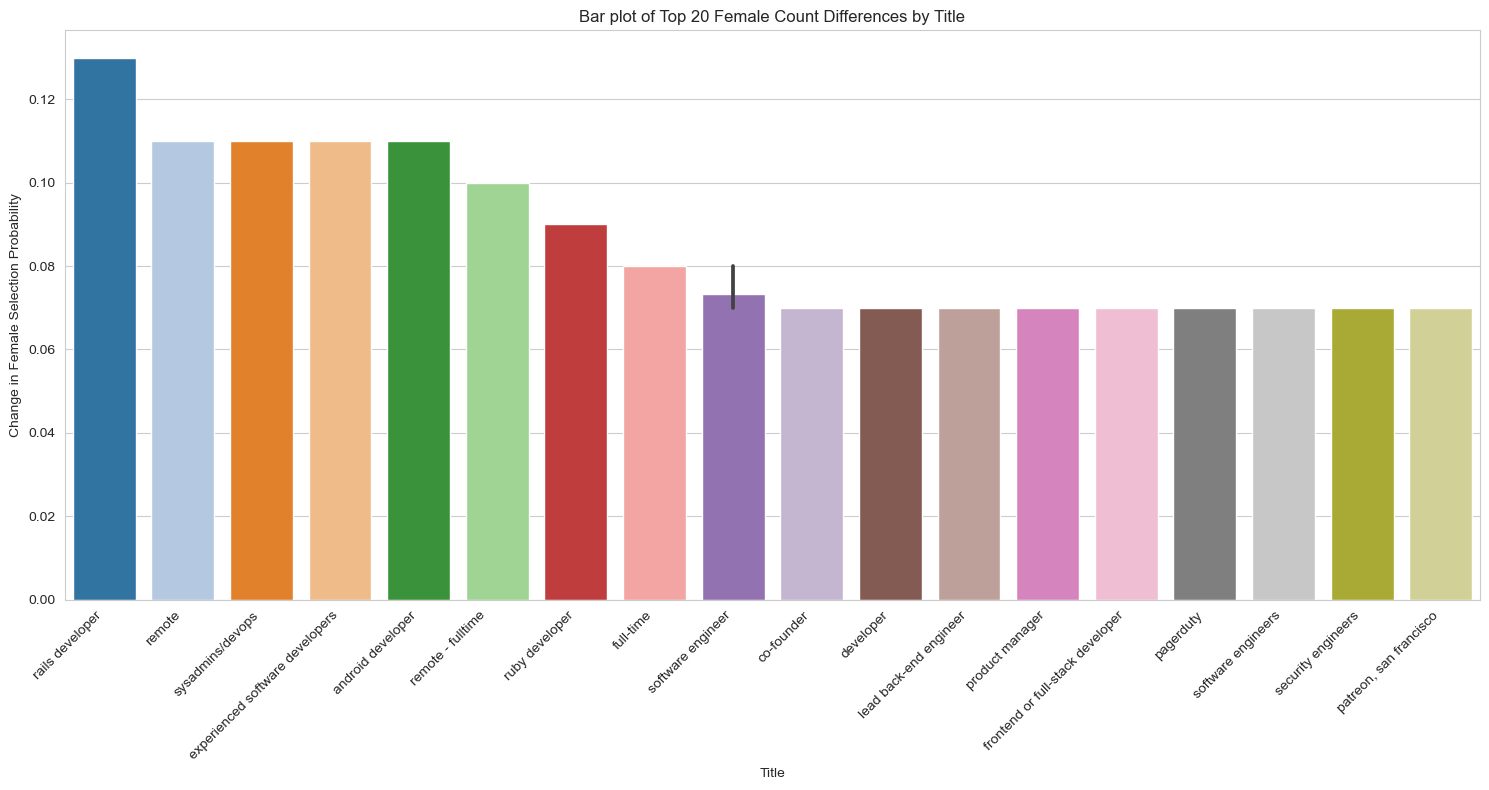

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert titles to lowercase to avoid case-sensitivity issues
merged_df['title'] = merged_df['title'].str.lower()

# Sort the dataframe by 'female_count_diff' and select the top 20
top_20_df = merged_df.sort_values(by='female_count_diff', ascending=False).head(20)

plt.figure(figsize=(15, 8))

# Use seaborn's barplot function to plot the top 20
sns.barplot(data=top_20_df, x='title', y='female_count_diff', palette='tab20')

plt.xlabel('Title')
plt.ylabel('Change in Female Selection Probability')
plt.title('Bar plot of Top 20 Female Count Differences by Title')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()



In [9]:
merged_df.groupby(['title']).count()

text  CommentTime_baseline  \
title                                                                         
\n                                                  2                     2   
\n- bs, ms or phd                                   1                     1   
\n-lead front end engineer                          1                     1   
#6                                                  2                     2   
20spokes - chicago, il ruby on rails developers     1                     1   
...                                               ...                   ...   
xtranormal                                          1                     1   
yc s12                                              1                     1   
yifteejobdescfrontendengineer                       1                     1   
zero one intern                                     1                     1   
~20 heads, 10 engineers                             1                     1   

                                                 CommentAuthor_baseline  \
title                                                                     
\n                                                                    2   
\n- bs, ms or phd                                                     1   
\n-lead front end engineer                                            1   
#6                                                                    2   
20spokes - chicago, il ruby on rails developers                       1   
...                                                                 ...   
xtranormal                                                            1   
yc s12                                                                1   
yifteejobdescfrontendengineer                                         1   
zero one intern                                                       1   
~20 heads, 10 engineers                                               1   

                                                 ParentTitle_baseline  \
title                                                                   
\n                                                                  2   
\n- bs, ms or phd                                                   1   
\n-lead front end engineer                                          1   
#6                                                                  2   
20spokes - chicago, il ruby on rails developers                     1   
...                                                               ...   
xtranormal                                                          1   
yc s12                                                              1   
yifteejobdescfrontendengineer                                       1   
zero one intern                                                     1   
~20 heads, 10 engineers                                             1   

                                                 clean_text_baseline  \
title                                                                  
\n                                                                 2   
\n- bs, ms or phd                                                  1   
\n-lead front end engineer                                         1   
#6                                                                 2   
20spokes - chicago, il ruby on rails developers                    1   
...                                                              ...   
xtranormal                                                         1   
yc s12                                                             1   
yifteejobdescfrontendengineer                                      1   
zero one intern                                                    1   
~20 heads, 10 engineers                                            1   

                                                 location_baseline  \
title                                                                
\n                

In [10]:
import spacy
from sklearn.cluster import KMeans

# Load a spaCy model (English medium model in this case)
nlp = spacy.load('en_core_web_lg')

# Convert titles to embeddings
embeddings = [nlp(title).vector for title in merged_df['title'].unique()]

# Decide the number of clusters (you might need to adjust this)
n_clusters = 75  # Example value

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Create a mapping from titles to their cluster labels
title_to_cluster = dict(zip(merged_df['title'].unique(), kmeans.labels_))

# Assign titles in the dataframe to their respective clusters
merged_df['title_cluster'] = merged_df['title'].map(title_to_cluster)

# Now, you can use the 'title_cluster' column as a processed title for aggregation or further analysis


/Users/busesibelkorkmaz/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
merged_df[['title', 'title_cluster']][merged_df.title_cluster == 15]

title  title_cluster
58                                     zero one intern             15
129                                          full time             15
146                full time senior software developer             15
152  full time\ngetlua.com\nwe're looking for an an...             15
163                                     full time, h1b             15
191                                          full time             15
200                                          full time             15
340                                          full time             15
371                                           fulltime             15
393                                          full time             15
403                                     full time, h1b             15
417                                  full time, intern             15
462                                  full time, intern             15
490                                          full time             15
521            full time .net and javascript engineers             15
541                                           fulltime             15

In [12]:
import numpy as np

def find_closest_title(cluster_center, embeddings, titles):
    distances = [np.linalg.norm(cluster_center - embedding) for embedding in embeddings]
    closest_index = np.argmin(distances)
    return titles[closest_index]

# Create a list of unique titles
unique_titles = merged_df['title'].unique()

# Find representative titles for each cluster
representative_titles = {}
for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    rep_title = find_closest_title(cluster_center, embeddings, unique_titles)
    representative_titles[i] = rep_title

# Map cluster numbers to representative titles
merged_df['title_cluster_name'] = merged_df['title_cluster'].map(representative_titles)


In [13]:
import pandas as pd

# Group by the processed_titles and sum the respective columns
grouped = merged_df.groupby('title_cluster_name').agg({
    'female_count_baseline': 'sum',
    'female_count_gendered': 'sum'
}).reset_index()

# Compute the difference between the two columns
grouped['female_count_diff'] = grouped['female_count_gendered'] - grouped['female_count_baseline']

grouped = grouped.sort_values(by='female_count_diff', ascending=False)  # Sorting by difference if needed

# Display the result
print(grouped[['title_cluster_name', 'female_count_baseline', 'female_count_gendered', 'female_count_diff']])


                                   title_cluster_name  female_count_baseline  \
30                                 frontend developer              12.990609   
36                                full-time developer               6.196667   
64                                software developers              10.900147   
43                               javascript developer               4.920000   
62  senior frontend engineer\n- senior backend eng...               1.970000   
..                                                ...                    ...   
74                                     web developers               6.223951   
44                               javascript-developer               4.600000   
33            full time .net and javascript engineers               8.896667   
73                          web applications engineer               1.980000   
63                        senior javascript developer              11.201046   

    female_count_gendered  female_count

In [14]:
# Filter out rows with certain values in the 'title_cluster_name' column
grouped_clean = grouped[~grouped['title_cluster_name'].isin(["finance guy", "engineer #2", "do"])]
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business development', 'business developer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business developer / assistant director', 'business developer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('data science, engineering', 'data engineer')

grouped_clean = grouped_clean.groupby('title_cluster_name').agg({
    'female_count_baseline': 'sum',
    'female_count_gendered': 'sum'
}).reset_index()

# Compute the difference between the two columns
grouped_clean['female_count_diff'] = grouped_clean['female_count_gendered'] - grouped_clean['female_count_baseline']

grouped_clean = grouped_clean.sort_values(by='female_count_diff', ascending=False)  # Sorting by difference if needed

/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/1592273152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business development', 'business developer')
/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/1592273152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business developer / assistant director', 'bu

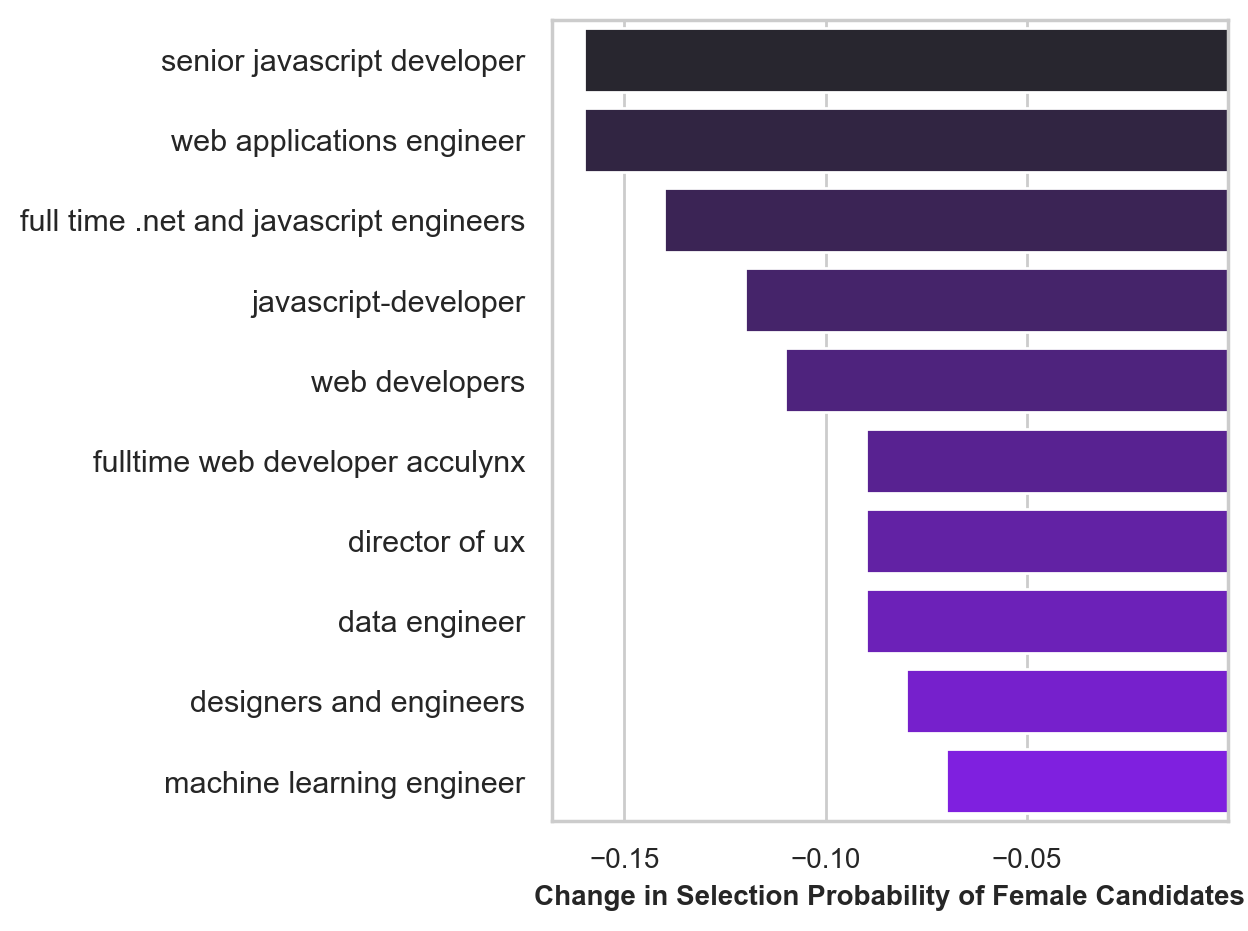

In [15]:
import textwrap

%config InlineBackend.figure_format = 'retina'

# Set the Seaborn style and font scale
sns.set(style='whitegrid')

# Set figure size and DPI (for high-quality image)
# plt.figure(figsize=(6, 8), dpi=300)  # Adjusted figure size for vertical plot

# Sort the data and select the top 10
top_10_df_female = grouped_clean.sort_values(by='female_count_diff', ascending=True).head(10)

# Use Seaborn's barplot function to plot the top 10 vertically
base_color = "#7F00FF"
palette = sns.dark_palette(base_color, n_colors=len(top_10_df_female))
sns.barplot(data=top_10_df_female, y='title_cluster_name', x='female_count_diff', palette=palette, orient='h')  # Switched x and y

min_val = -0.15  # Get minimum value
max_val = top_10_df_female['female_count_diff'].max()  # Get maximum value
plt.xticks(np.arange(min_val, max_val + 0.05, 0.05), fontsize=10)  # Set x-ticks

# Customize axis labels and title
plt.ylabel('', fontweight='bold', fontsize=12)
plt.xlabel('Change in Selection Probability of Female Candidates', fontweight='bold', fontsize=10)

# Adjust tick font sizes
# Show the plot
plt.tight_layout()
plt.show()

In [16]:
grouped= merged_df.groupby('title_cluster_name').agg({
    'male_count_baseline': 'sum',
    'male_count_gendered': 'sum'
}).reset_index()

grouped_clean = grouped[~grouped['title_cluster_name'].isin(["finance guy", "engineer #2", "do", "competitive salary and equity", "remote", "qualcomm r&#38;d\n"])]
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business development', 'business developer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business developer / assistant director', 'business developer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('data science, engineering', 'data engineer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('frontend developer', 'front-end developer')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('full-time developer', 'software developers')
grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('remote engineering team', 'engineer')

grouped_clean = grouped_clean.groupby('title_cluster_name').agg({
    'male_count_baseline': 'sum',
    'male_count_gendered': 'sum'
}).reset_index()

# Compute the difference between the two columns
grouped_clean['male_count_diff'] = grouped_clean['male_count_gendered'] - grouped_clean['male_count_baseline']

grouped_clean = grouped_clean.sort_values(by='male_count_diff', ascending=False)  # Sorting by difference if needed

/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/3092373394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business development', 'business developer')
/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/3092373394.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_clean['title_cluster_name'] = grouped_clean['title_cluster_name'].replace('business developer / assistant director', 'bu

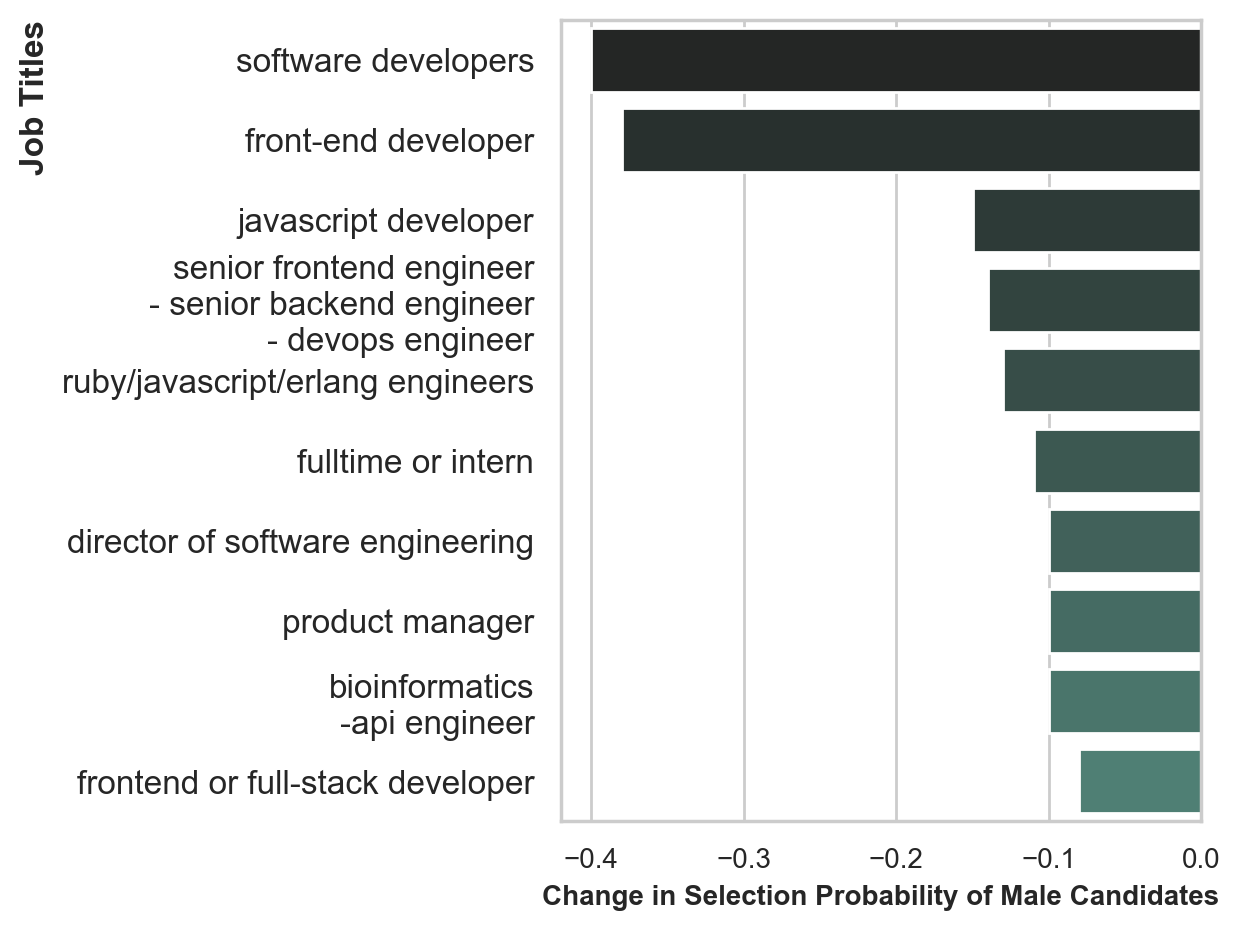

In [17]:
# # Set the Seaborn style and font scale
# sns.set(style='whitegrid')

# Set figure size and DPI (for high-quality image)
# plt.figure(figsize=(6, 8), dpi=300)  # Adjusted figure size for vertical plot

# Sort the data and select the top 10
top_10_df_male = grouped_clean.sort_values(by='male_count_diff', ascending=True).head(10)

# Use Seaborn's barplot function to plot the top 10 vertically
base_color = "#478778"
palette = sns.dark_palette(base_color, n_colors=len(top_10_df_male))
sns.barplot(data=top_10_df_male, y='title_cluster_name', x='male_count_diff', palette=palette, orient='h')  # Switched x and y

# Customize axis labels and title
plt.ylabel('Job Titles', fontweight='bold', fontsize=12,loc='top')
plt.xlabel('Change in Selection Probability of Male Candidates', fontweight='bold', fontsize=10)

# Adjust tick font sizes
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
# top_20_df['title_cluster_name']

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

sns.set_style("white")

def clean_and_group(df, gender):
    column_prefix = f"{gender}_count"
    
    # Cleaning titles
    replacements = {
        'business development': 'business developer',
        'business developer / assistant director': 'business developer',
        'data science, engineering': 'data engineer',
        'frontend developer': 'front-end developer',
        'full-time developer': 'software developers',
        'remote engineering team': 'engineer'

    }

    df = df[~df['title_cluster_name'].isin(["finance guy", "engineer #2", "do", "competitive salary and equity", "remote", "qualcomm r&#38;d\n"])]
    
    for old, new in replacements.items():
        df['title_cluster_name'] = df['title_cluster_name'].replace(old, new)
    
    # Grouping by title
    grouped = df.groupby('title_cluster_name').agg({
        f'{column_prefix}_baseline': 'sum',
        f'{column_prefix}_gendered': 'sum'
    }).reset_index()

    # Compute the difference
    grouped[f'{column_prefix}_diff'] = grouped[f'{column_prefix}_gendered'] - grouped[f'{column_prefix}_baseline']
    
    return grouped.sort_values(by=f'{column_prefix}_diff', ascending=False)

# Process female and male data
grouped_female = clean_and_group(merged_df, 'female')
grouped_male = clean_and_group(merged_df, 'male')

# Combine the dataframes to get a single dataframe for plotting
merged_grouped = pd.merge(grouped_female, grouped_male, on="title_cluster_name", how="inner").fillna(0)

# # Take top 10 records for each gender
top_10_female = merged_grouped.sort_values(by='female_count_diff', ascending=True).head(10)
# print(top_10_female)

top_10_male = merged_grouped.sort_values(by='male_count_diff', ascending=True).head(10)
# print(top_10_male)

# Concatenate the two dataframes
top_20_df = pd.concat([top_10_female, top_10_male], ignore_index=True)

# Plotting
# sns.set(style='whitegrid')
# Use a palette for better color contrast and aesthetic look
palette = sns.color_palette("pastel")
female_color = palette[0]
male_color = palette[3]

# Plot size
plt.figure(figsize=(12, 6), dpi=512)

# Bar width for better distinction and visibility
bar_width = 0.4
r1 = range(len(top_20_df))
r2 = [x + bar_width for x in r1]

# Plot male and female bars side by side for each title
sns.barplot(data=top_20_df, x='title_cluster_name', y='female_count_diff', color='#009688', label='Female')
sns.barplot(data=top_20_df, x='title_cluster_name', y='male_count_diff', color='#D55E00', label='Male', alpha=0.6)  # Setting alpha for better visibility in case of overlaps

# Customize axis labels, title, and legend
# plt.title('Change in Probability for Job Titles by Gender', fontweight='bold', fontsize=12)
plt.xlabel('Job Titles', fontweight='bold', fontsize=12)
plt.ylabel('Change in Probability', fontweight='bold', fontsize=12)
wrapped_labels = [textwrap.fill(label, width=22) for label in top_20_df['title_cluster_name']]
plt.xticks([r + bar_width for r in range(len(top_20_df))], wrapped_labels, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)
plt.legend(loc='upper right', fontsize=14, frameon=True)

# Aesthetic tweaks: Remove unnecessary spines
sns.despine(top=True, right=True)

# Ensure layout fits and then display the plot
plt.tight_layout()
plt.show()


/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/2316622251.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_cluster_name'] = df['title_cluster_name'].replace(old, new)
/var/folders/1c/0bpl5xzn2gdb890pwsldb15h0000gn/T/ipykernel_56106/2316622251.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_cluster_name'] = df['title_cluster_name'].replace(old, new)


In [21]:
import textwrap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Set the Seaborn style and font scale
sns.set(style='whitegrid')

# Set figure size and DPI (for high-quality image)
fig = plt.figure(figsize=(12, 12), dpi=300)  # Adjusted figure size for vertical plot


# First subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot

# Use Seaborn's barplot function to plot the top 10 vertically
base_color = "#7F00FF"
palette = sns.dark_palette(base_color, n_colors=len(top_10_df_female))
sns.barplot(data=top_10_df_female, y='title_cluster_name', x='female_count_diff', palette=palette, orient='h')

min_val = -0.15  # Get minimum value
max_val = top_10_df_female['female_count_diff'].max()  # Get maximum value
plt.xticks(np.arange(min_val, max_val + 0.05, 0.05), fontsize=10)  # Set x-ticks
plt.yticks(fontsize=17)

# Customize axis labels and title
plt.ylabel('', fontweight='bold', fontsize=12)
plt.xlabel('Change in Selection Probability of Female Candidates', fontweight='bold', fontsize=16)

# Second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot

# Use Seaborn's barplot function to plot the top 10 vertically
base_color = "#478778"
palette = sns.dark_palette(base_color, n_colors=len(top_10_df_male))
sns.barplot(data=top_10_df_male, y='title_cluster_name', x='male_count_diff', palette=palette, orient='h')

# Customize axis labels and title
plt.ylabel('', fontweight='bold', fontsize=12)
plt.xlabel('Change in Selection Probability of Male Candidates', fontweight='bold', fontsize=16)

fig.text(0.04, 0.5, 'Job Titles', va='center', rotation='vertical', fontweight='bold', fontsize=16)

# Adjust tick font sizes
plt.yticks(fontsize=17)
plt.xticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [22]:
print(grouped_male)

                                   title_cluster_name  male_count_baseline  \
64                          web applications engineer             2.020000   
54                        senior javascript developer            10.798954   
28            full time .net and javascript engineers             7.103333   
38                               javascript-developer             4.400000   
65                                     web developers             5.776049   
..                                                ...                  ...   
51                   ruby/javascript/erlang engineers             9.067901   
53  senior frontend engineer\n- senior backend eng...             2.030000   
37                               javascript developer             5.080000   
23                                front-end developer            13.009391   
55                                software developers            17.903187   

    male_count_gendered  male_count_diff  
64             2.180